In [3]:
# %pip install numpy
# %pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
def imgshow(name, img):
    cv2.imshow(name, img)
    cv2.moveWindow(name, 200, 200)
    cv2.waitKey(0)


img = cv2.imread('./images/IMG_0199.JPG')


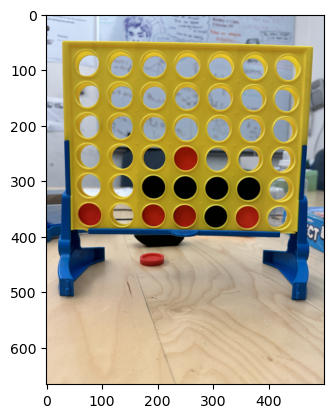

In [55]:
new_width = 500
img_h, img_w, _ = img.shape
scale = new_width / img_w
img_w = int(img_w * scale)
img_h = int(img_h * scale)
img = cv2.resize(img, (img_w, img_h), interpolation=cv2.INTER_AREA)
# Make a copy of the image
image_copy = np.copy(img)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

plt.imshow(image_copy)
plt.show()

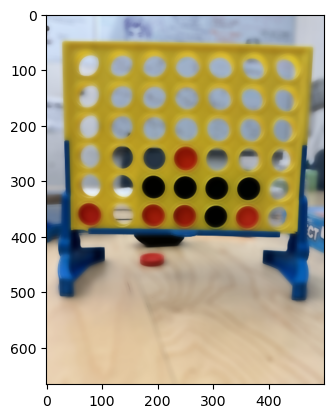

In [56]:
#Bilateral Filter

bilateral_filtered_image = cv2.bilateralFilter(image_copy, 15, 190, 190)
plt.imshow(bilateral_filtered_image)
plt.show()

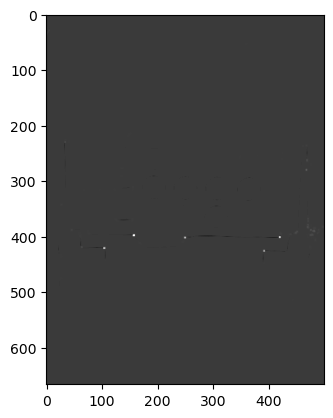

In [57]:

# #Harris Corner Detection Algorithm: https://medium.com/@deepanshut041/introduction-to-harris-corner-detector-32a88850b3f6
# # Convert to grayscale
# gray = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_RGB2GRAY)
# gray = np.float32(gray)

# # Detect corners 
# dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# # Dilate corner image to enhance corner points
# dst = cv2.dilate(dst,None)

# plt.imshow(dst, cmap='gray')

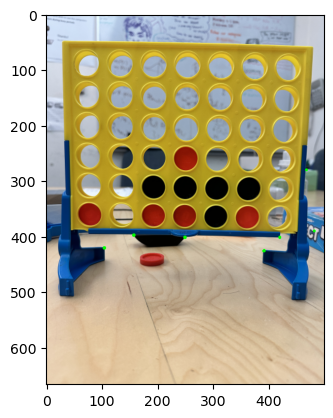

In [58]:
# This value vary depending on the image and how many corners you want to detect
# Try changing this free parameter, 0.1, to be larger or smaller and see what happens
thresh = 0.1*dst.max()

# Create an image copy to draw corners on
corner_image = np.copy(image_copy)

# Iterate through all the corners and draw them on the image (if they pass the threshold)
for j in range(0, dst.shape[0]):
    for i in range(0, dst.shape[1]):
        if(dst[j,i] > thresh):
            # image, center pt, radius, color, thickness
            cv2.circle( corner_image, (i, j), 1, (0,255,0), 1)

plt.imshow(corner_image)

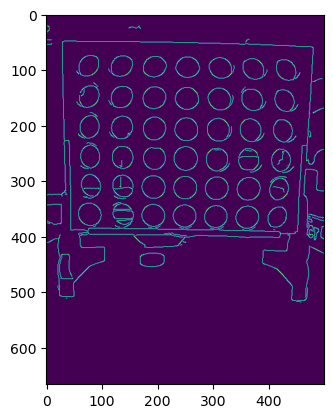

In [66]:
# Outline Edges
edge_detected_image = cv2.Canny(bilateral_filtered_image, 75, 150)
plt.imshow(edge_detected_image)
plt.show()

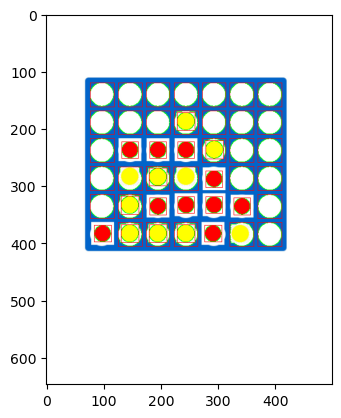

In [40]:
# Find Circles
contours, hierarchy = cv2.findContours(
    edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_list = []
rect_list = []
position_list = []

for contour in contours:
    approx = cv2.approxPolyDP(
        contour, 0.01*cv2.arcLength(contour, True), True)
    area = cv2.contourArea(contour)

    rect = cv2.boundingRect(contour)
    x_rect, y_rect, w_rect, h_rect = rect
    x_rect += w_rect/2
    y_rect += h_rect/2
    area_rect = w_rect*h_rect

    if ((len(approx) > 8) & (len(approx) < 23) & (area > 250) & (area_rect < (img_w*img_h)/5)) & (w_rect in range(h_rect-10, h_rect+10)):  # Circle conditions
        contour_list.append(contour)
        position_list.append((x_rect, y_rect))
        rect_list.append(rect)

img_circle_contours = img_orig.copy()
cv2.drawContours(img_circle_contours, contour_list,  -1,
                 (0, 255, 0), thickness=1)  # Display Circles
for rect in rect_list:
    x, y, w, h = rect
    cv2.rectangle(img_circle_contours, (x, y), (x+w, y+h), (0, 0, 255), 1)

img_circle_contours_rgb = cv2.cvtColor(img_circle_contours, cv2.COLOR_BGR2RGB)

# Use matplotlib to display the image
plt.imshow(img_circle_contours_rgb)
plt.show()

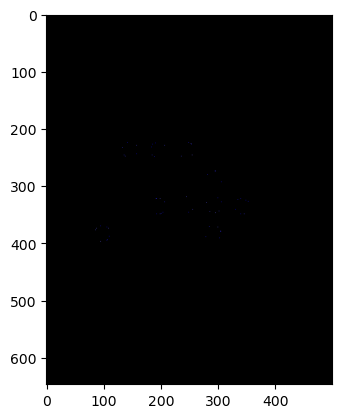

In [41]:

# Interpolate Grid
rows, cols = (6, 7)
mean_w = sum([rect[2] for r in rect_list]) / len(rect_list)
mean_h = sum([rect[3] for r in rect_list]) / len(rect_list)
position_list.sort(key=lambda x: x[0])
max_x = int(position_list[-1][0])
min_x = int(position_list[0][0])
position_list.sort(key=lambda x: x[1])
max_y = int(position_list[-1][1])
min_y = int(position_list[0][1])
grid_width = max_x - min_x
grid_height = max_y - min_y
col_spacing = int(grid_width / (cols-1))
row_spacing = int(grid_height / (rows - 1))

# Find Masks
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_red = np.array([150, 150, 100])
upper_red = np.array([255, 255, 255])
mask_red = cv2.inRange(img_hsv, lower_red, upper_red)
img_red = cv2.bitwise_and(img, img, mask=mask_red)

plt.imshow(img_red)
plt.show()

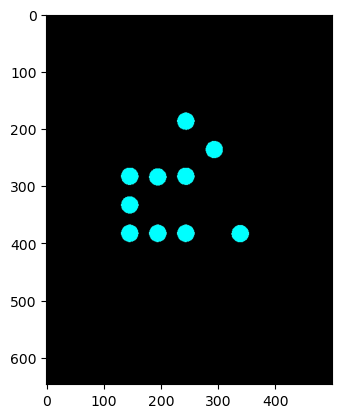

In [42]:

lower_yellow = np.array([10, 150, 100])
upper_yellow = np.array([60, 255, 255])
mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
img_yellow = cv2.bitwise_and(img, img, mask=mask_yellow)
plt.imshow(img_yellow)
plt.show()

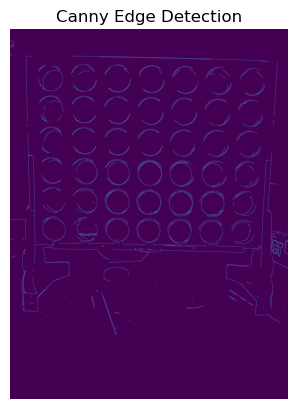

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Correct the path to the image
img = cv2.imread('./images/IMG_0199.JPG')


# Apply bilateral filter to reduce noise and keep edges sharp
bilateral_filtered_image = cv2.bilateralFilter(img, 9, 75, 75)

# Convert to grayscale
gray_image = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_BGR2GRAY)

# Use Canny algorithm to detect edges
canny_edges = cv2.Canny(gray_image, threshold1=75, threshold2=150)

# Show the image using Matplotlib (note: the color map is set to 'gray')
plt.imshow(canny_edges)
plt.title('Canny Edge Detection')
plt.axis('off')  # Hide the x and y axes
plt.show()


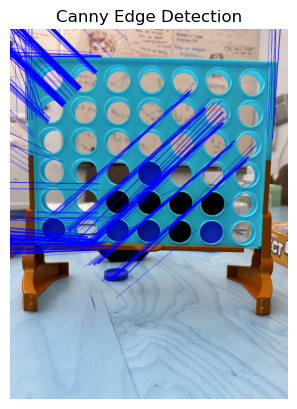

Detected lines:
[[2.3250000e+03 1.5882496e+00]]
[[286.          1.5882496]]
[[2.3220000e+03 1.5882496e+00]]
[[2.3840000e+03 1.5882496e+00]]
[[254.          1.6057029]]
[[282.          1.5882496]]
[[2.3330000e+03 1.5882496e+00]]
[[250.          1.6057029]]
[[2.3380000e+03 1.5707964e+00]]
[[2.2960000e+03 1.6057029e+00]]
[[49.         2.7925267]]
[[1086.          2.146755]]
[[2.2900000e+03 1.6057029e+00]]
[[2.935000e+03 6.981317e-02]]
[[2.855000e+03 5.235988e-02]]
[[2.2990000e+03 1.6057029e+00]]
[[2.3290000e+03 1.5882496e+00]]
[[1021.           2.1642082]]
[[-9.         2.8099802]]
[[257.          1.6057029]]
[[182.          2.3561945]]
[[2.2870000e+03 1.6057029e+00]]
[[2.278000e+03 7.853982e-01]]
[[2.883000e+03 6.981317e-02]]
[[2.3480000e+03 1.5707964e+00]]
[[2.0620000e+03 8.3775806e-01]]
[[-148.          3.106686]]
[[2.3350000e+03 1.5882496e+00]]
[[2.3340000e+03 1.5707964e+00]]
[[2.3500000e+03 1.5707964e+00]]
[[2.3820000e+03 1.5882496e+00]]
[[2.2830000e+03 1.6057029e+00]]
[[2.2450000e+0

In [5]:
import cv2
import numpy as np

def detect_corners(image_path):
    # Read the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Use the Canny edge detector to find edges in the image
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Use the Hough transform to detect lines in the edge-detected image
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Display the lines
    plt.imshow(img)
    plt.title('Canny Edge Detection')
    plt.axis('off')  # Hide the x and y axes
    plt.show()


    # Finding corners by intersecting lines can be done by implementing
    # a function that takes the lines found by the Hough transform, 
    # then finds intersections to locate the corners.
    # This step is complex and requires additional implementation.

    # For now, we print the lines to see if they align well with the board edges
    print("Detected lines:")
    for line in lines:
        print(line)

# Replace with the path to your image
image_path = './images/IMG_0199.JPG'
detect_corners(image_path)


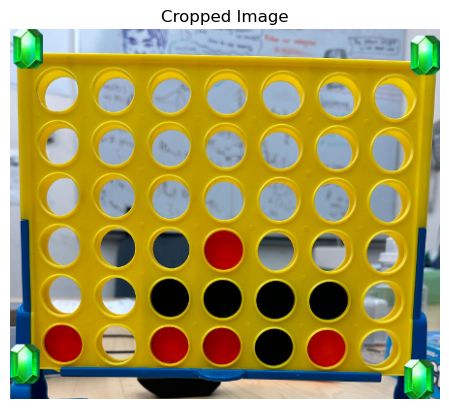

In [24]:
#try out zelda rupee markers

import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_to_rupees(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Apply bilateral filter
    filtered = cv2.bilateralFilter(image, 9, 75, 75)

    # Convert to HSV
    hsv = cv2.cvtColor(filtered, cv2.COLOR_BGR2HSV)

    # Define range for green color of the rupees
    lower_green = np.array([45, 100, 50])   # Adjust these values
    upper_green = np.array([75, 255, 255])  # Adjust these values

    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest contours correspond to the rupees
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:4]

    # Determine the bounding box around the rupees
    if contours:
        # Find the extreme points
        left = min([cv2.boundingRect(c)[0] for c in contours])
        top = min([cv2.boundingRect(c)[1] for c in contours])
        right = max([cv2.boundingRect(c)[0] + cv2.boundingRect(c)[2] for c in contours])
        bottom = max([cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3] for c in contours])

        # Crop the image
        cropped_image = image[top:bottom, left:right]

        # Convert BGR image to RGB for Matplotlib
        cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

        # Display the cropped image
        plt.imshow(cropped_image_rgb)
        plt.title('Cropped Image')
        plt.axis('off')
        plt.show()

        return cropped_image  # This is the cropped image

    else:
        print("No rupees detected.")
        return None

# Replace with the path to your image
image_path = './images/zelda.png'
cropped_image = crop_to_rupees(image_path)
new_width = 500
img_h, img_w, _ = cropped_image.shape
scale = new_width / img_w
img_w = int(img_w * scale)
img_h = int(img_h * scale)
img = cv2.resize(cropped_image, (img_w, img_h), interpolation=cv2.INTER_AREA)


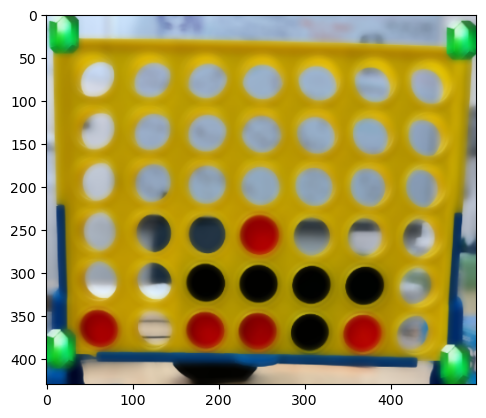

In [25]:
image_copy = np.copy(img)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)


bilateral_filtered_image = cv2.bilateralFilter(image_copy, 15, 190, 190)
plt.imshow(bilateral_filtered_image)
plt.show()

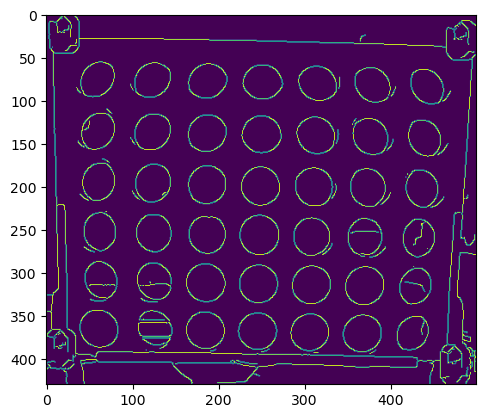

In [26]:
# Outline Edges
edge_detected_image = cv2.Canny(bilateral_filtered_image, 75, 150)
plt.imshow(edge_detected_image)
plt.show()

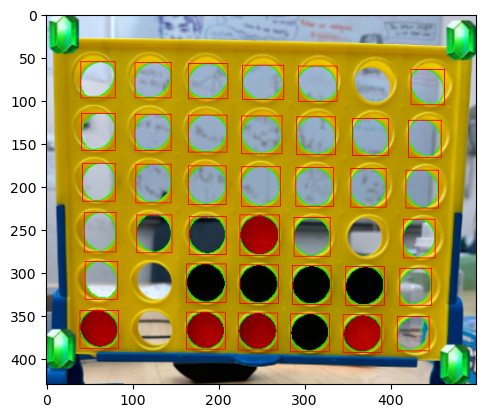

In [29]:
# Find Circles
contours, hierarchy = cv2.findContours(
    edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_list = []
rect_list = []
position_list = []

for contour in contours:
    approx = cv2.approxPolyDP(
        contour, 0.01*cv2.arcLength(contour, True), True)
    area = cv2.contourArea(contour)

    rect = cv2.boundingRect(contour)
    x_rect, y_rect, w_rect, h_rect = rect
    x_rect += w_rect/2
    y_rect += h_rect/2
    area_rect = w_rect*h_rect

    if ((len(approx) > 8) & (len(approx) < 23) & (area > 250) & (area_rect < (img_w*img_h)/5)) & (w_rect in range(h_rect-10, h_rect+10)):  # Circle conditions
        contour_list.append(contour)
        position_list.append((x_rect, y_rect))
        rect_list.append(rect)

img_circle_contours = img.copy()
cv2.drawContours(img_circle_contours, contour_list,  -1,
                 (0, 255, 0), thickness=1)  # Display Circles
for rect in rect_list:
    x, y, w, h = rect
    cv2.rectangle(img_circle_contours, (x, y), (x+w, y+h), (0, 0, 255), 1)

img_circle_contours_rgb = cv2.cvtColor(img_circle_contours, cv2.COLOR_BGR2RGB)

# Use matplotlib to display the image
plt.imshow(img_circle_contours_rgb)
plt.show()

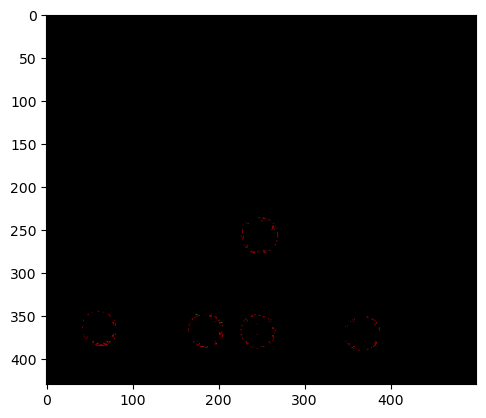